# Intraoperative traction influence on patient reported outcomes measures (PROMs) after hip arthroscopy

## Hypothesis

1. Increased **surgical time** will be associated with **decreased likelihood** of achieving the minimal clinically important difference (**MCID**) and/or substantial clinical benefit (**SCB**) after **arthroscopic treatment** of femoroacetabular impingement (**FAI**)
2. Increased **traction time** will be associated with **decreased likelihood** of achieving the **MCID** and/or **SCB** after **arthroscopic treatment** of **FAI**

## Background

- Hip arthroscopy is a viable and successful option in Mx of non-arthritic hip disease
- Hip arthroscopy is demanding (constant traction) and has a high learning curve (requires a large case and regular case load)
- Previous **inverse correlation** between **surgical volume vs. surgical duration + complication rates**
- Little research on hip arthroscopy duration + traction vs PROMs

## Aims

Patient review postoperatively at:

- 6 months
- 12 months
- 24 months

Using four PROMs: 

1. modified Harris Hip Score (mHHS)
2. Hip-Outcome Score - Activities of Daily Living (HOS-ADL)
3. Hip Outcome Score - Sports Specific (HOS-SS)
4. international Hip Outcome Tool (iHOT-33)

### Primary

Illustrate effect of surgical duration on achievement of threshold scores such as MCID ± SCB after arthroscopic treatment of FAI (cam decompression and labral repair)

### Secondary

Effect of traction duration on achievement rates of threshold scores.
> Multivariable analysis controlling for age, sex, baseline PROMs scores and pre-operative diagnosis to determine if surgical duration ± traction duration can be considered independent risk factors (RFs) for achieving, or failure to achieve, threshold scores on PROMs after hip arthroscopy

### Inclusion Criteria

- Ages 18-80
- Primary arthroscopic hip surgery performed at HSS
- Minimum of pre-operative completed questionnaire
- Primary hip arthroscopy consisted of cam decompression and labral repair

### Exclusion Criteria

- Prior history of ipsilateral hip surgery
- Pre-existing congenital hip condition
- High grade osteoarthritis (defined as Tonnis grade > 2)

## Reference values

Prior literature has shown utilization of the following reference values at both 6 and 24 months time points after hip arthroscopy

References values for MCID:

- mHHS = 8.2
- HOS-ADL = 8.3
- HOS-SS = 14.5
- iHOT-33 = 12.1

SCB values will be reported as an absolute score (instead of a change score):
- mHHS = 82.5
- HOS-ADL = 93.3
- HOS-SS = 84.4
- iHOT-33 = 63.5


In [1]:
# stats libs
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas_profiling import ProfileReport

# graph libs
import seaborn as sns
sns.set_theme()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *

# ensure reproducibility
np.random.seed(123)

#ignore errors about using jupyter notebook or sample size being too small
import warnings
warnings.simplefilter("ignore", UserWarning) 

In [2]:
df = pd.read_csv('data/traction.csv')
# drop all patient identifiable information
df = df.drop(columns=[
  'PID', 
  'SID', 
  'SMDateofSurgery', 
  'LastName', 
  'FirstName', 
  'DateofBirth'
  ])

In [3]:
df.head()

,side,Sex,age,Procedure,Surgeon,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,...,nFU6m,nFU1y,nFU2y,nFU3y,nFU4y,nFU5y,nFU6y,nFU7y,nFU8y,nFU9y
0,LEFT,M,26,Scope,BK,0.0,0.0,0.0,0.0,0.0,...,4,0,4,0,0,0,0,0,0,0
1,RIGHT,F,27,Scope,BK,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,RIGHT,M,18,Scope,AR,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,RIGHT,M,35,Scope,AR,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,RIGHT,M,21,Scope,AR,0.0,1.0,1.0,1.0,0.0,...,0,4,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3528 entries, 0 to 3527
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   side                            3527 non-null   object 
 1   Sex                             3528 non-null   object 
 2   age                             3528 non-null   int64  
 3   Procedure                       3528 non-null   object 
 4   Surgeon                         3528 non-null   object 
 5   PreDiagRevision                 3008 non-null   float64
 6   PreDiagLabTear                  3007 non-null   float64
 7   PreDiagCam                      3007 non-null   float64
 8   PreDiagPincer                   3007 non-null   float64
 9   ProcLTDwPres                    3008 non-null   float64
 10  ProcLTDwRefix                   3008 non-null   float64
 11  ProcCamDecom                    3008 non-null   float64
 12  ProcRimDecom                    30

In [5]:
# drop the one row where we don't have the side info
df = df.dropna(subset='side')

In [6]:
# drop the rows where we don't have the traction info
df.loc[:, 'GeneralTractionTime':'GeneralSurgeryTime'] = df.loc[:, 'GeneralTractionTime':'GeneralSurgeryTime'].replace(to_replace='x', value=np.nan)
df = df.dropna(subset=['GeneralTractionTime'])
df['GeneralTractionTime'] = df['GeneralTractionTime'].astype(np.int64)
df['GeneralSurgeryTime'] = df['GeneralSurgeryTime'].replace(to_replace='bilateral', value=np.nan).astype(np.float64)

In [7]:
# look into detail on the surgical stats
col_surg_stats = df.loc[:, 'PreDiagRevision':'simultane'].columns
df.loc[:, col_surg_stats].describe()

,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,ProcLTDwRefix,ProcCamDecom,ProcRimDecom,NoComplication,ComplicationDamageLab,...,ComplicationInstBreak,ComplicationHeadScuff,ComplicationDifficultTraction,ComplicationIatrogenicCartInj,GeneralTractionTime,GeneralSurgeryTime,GeneralFluidBags,PCVCamLesion,surgery_yr,simultane
count,2673.0,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,...,2673.000000,2673.000000,2673.000000,2673.0,3034.000000,3013.000000,2399.000000,2673.0,3034.000000,111.0
mean,0.0,0.980546,0.895623,0.371493,0.131313,0.852974,0.893378,0.368874,0.905350,0.0,...,0.000748,0.003741,0.001871,0.0,45.178642,81.423498,3.865777,0.0,2013.874753,1.0
std,0.0,0.138139,0.305806,0.483294,0.337806,0.354198,0.308690,0.482590,0.292786,0.0,...,0.027349,0.061062,0.043218,0.0,13.545313,28.196190,59.403698,0.0,2.287339,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.0,2009.000000,1.0
25%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,35.000000,70.000000,1.000000,0.0,2012.000000,1.0
50%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,45.000000,77.000000,1.000000,0.0,2014.000000,1.0
75%,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,51.000000,90.000000,1.000000,0.0,2016.000000,1.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,0.0,150.000000,900.000000,1600.000000,0.0,2018.000000,1.0


**Dropping unclear columns**

- GeneralFluidBags - incomplete dataset, and unclear if necessary for this analysis
- simultane - incomplete dataset only 179 values, therefore dropped as unusable
- drop follow-up > 2 years as to low numbers for analysis
- nFU columns - unclear what these are for, as followup is already documented in scores

In [8]:
df = df.drop(columns=[
  'GeneralFluidBags', 
  'simultane',
  'HHS23to35mScoreLast',
  'HHS35to47mScoreLast',
  'HHS47to59mScoreLast',
  'HHS59to71mScoreLast',
  'HHS71to83mScoreLast',
  'HHS83to95mScoreLast',
  'HHS95to107mScoreLast',
  'HHS107to119mScoreLast',
  'HOSADL23to35mScoreLast',
  'HOSADL35to47mScoreLast',
  'HOSADL47to59mScoreLast',
  'HOSADL59to71mScoreLast',
  'HOSADL71to83mScoreLast',
  'HOSADL83to95mScoreLast',
  'HOSADL95to107mScoreLast',
  'HOSADL107to119mScoreLast',
  'HOSSport23to35mScoreLast',
  'HOSSport35to47mScoreLast',
  'HOSSport47to59mScoreLast',
  'HOSSport59to71mScoreLast',
  'HOSSport71to83mScoreLast',
  'HOSSport83to95mScoreLast',
  'HOSSport95to107mScoreLast',
  'HOSSport107to119mScoreLast',
  'QOL23to35mScoreLast',
  'QOL35to47mScoreLast',
  'QOL47to59mScoreLast',
  'QOL59to71mScoreLast',
  'QOL71to83mScoreLast',
  'QOL83to95mScoreLast',
  'QOL95to107mScoreLast',
  'QOL107to119mScoreLast',
  'nPre',
  'nFU6m',
  'nFU1y',
  'nFU2y',
  'nFU3y',
  'nFU4y',
  'nFU5y',
  'nFU6y',
  'nFU7y',
  'nFU8y',
  'nFU9y',
])
col_surg_stats = df.loc[:, 'PreDiagRevision':'PCVCamLesion'].columns
col_surg_stats

Index(['PreDiagRevision', 'PreDiagLabTear', 'PreDiagCam', 'PreDiagPincer',
       'ProcLTDwPres', 'ProcLTDwRefix', 'ProcCamDecom', 'ProcRimDecom',
       'NoComplication', 'ComplicationDamageLab',
       'ComplicationFluidExtPeriCavity', 'ComplicationInstBreak',
       'ComplicationHeadScuff', 'ComplicationDifficultTraction',
       'ComplicationIatrogenicCartInj', 'OtherComplication',
       'GeneralTractionTime', 'GeneralSurgeryTime', 'PCVCamLesion'],
      dtype='object')

In [9]:
col_surg_bool = col_surg_stats.copy().drop(['GeneralTractionTime', 'GeneralSurgeryTime', 'OtherComplication'])
col_surg_bool

Index(['PreDiagRevision', 'PreDiagLabTear', 'PreDiagCam', 'PreDiagPincer',
       'ProcLTDwPres', 'ProcLTDwRefix', 'ProcCamDecom', 'ProcRimDecom',
       'NoComplication', 'ComplicationDamageLab',
       'ComplicationFluidExtPeriCavity', 'ComplicationInstBreak',
       'ComplicationHeadScuff', 'ComplicationDifficultTraction',
       'ComplicationIatrogenicCartInj', 'PCVCamLesion'],
      dtype='object')

In [10]:
df.loc[:, col_surg_stats].describe()

,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,ProcLTDwRefix,ProcCamDecom,ProcRimDecom,NoComplication,ComplicationDamageLab,ComplicationFluidExtPeriCavity,ComplicationInstBreak,ComplicationHeadScuff,ComplicationDifficultTraction,ComplicationIatrogenicCartInj,GeneralTractionTime,GeneralSurgeryTime,PCVCamLesion
count,2673.0,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,3034.000000,3013.000000,2673.0
mean,0.0,0.980546,0.895623,0.371493,0.131313,0.852974,0.893378,0.368874,0.905350,0.0,0.001122,0.000748,0.003741,0.001871,0.0,45.178642,81.423498,0.0
std,0.0,0.138139,0.305806,0.483294,0.337806,0.354198,0.308690,0.482590,0.292786,0.0,0.033489,0.027349,0.061062,0.043218,0.0,13.545313,28.196190,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0
25%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,35.000000,70.000000,0.0
50%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,45.000000,77.000000,0.0
75%,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,51.000000,90.000000,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,150.000000,900.000000,0.0


**ASSUMPTION**

`null` values are considered a negative value for the column, therefore:

fill ~500 rows that have `null` values with default `0.0`

In [11]:
# no complication = True therefore a different fill
df['NoComplication'] = df['NoComplication'].fillna(1)
df.loc[:, col_surg_bool] = df.loc[:, col_surg_bool].fillna(0)
df.loc[:, col_surg_bool] = df.loc[:, col_surg_bool].astype(np.bool_)

In [12]:
df.loc[:, col_surg_bool].describe()

,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,ProcLTDwRefix,ProcCamDecom,ProcRimDecom,NoComplication,ComplicationDamageLab,ComplicationFluidExtPeriCavity,ComplicationInstBreak,ComplicationHeadScuff,ComplicationDifficultTraction,ComplicationIatrogenicCartInj,PCVCamLesion
count,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034
unique,1,2,2,2,2,2,2,2,2,1,2,2,2,2,1,1
top,False,True,True,False,False,True,True,False,True,False,False,False,False,False,False,False
freq,3034,2621,2394,2041,2683,2280,2388,2048,2781,3034,3031,3032,3024,3029,3034,3034


In [13]:
df.loc[:, col_surg_bool].mean()

PreDiagRevision                   0.000000
PreDiagLabTear                    0.863876
PreDiagCam                        0.789057
PreDiagPincer                     0.327291
ProcLTDwPres                      0.115689
ProcLTDwRefix                     0.751483
ProcCamDecom                      0.787080
ProcRimDecom                      0.324984
NoComplication                    0.916612
ComplicationDamageLab             0.000000
ComplicationFluidExtPeriCavity    0.000989
ComplicationInstBreak             0.000659
ComplicationHeadScuff             0.003296
ComplicationDifficultTraction     0.001648
ComplicationIatrogenicCartInj     0.000000
PCVCamLesion                      0.000000
dtype: float64

**Analyzing the surgical details**

- No patients had previous revisions so no need to drop any of them
- Majority of patients had a diagnosis of labral tears 76% ± CAM 69%
- Pincer diagnosis in 28%
- 84% of patients had no complication
- <1% of patients were considered a difficult traction case

In [14]:
col_category = ['side', 'Sex', 'Procedure', 'Surgeon']
for col in col_category:
  df[col] = df[col].astype('category')

In [15]:
df[col_category].describe()

,side,Sex,Procedure,Surgeon
count,3034,3034,3034,3034
unique,2,2,1,4
top,RIGHT,M,Scope,BK
freq,1661,1569,3034,2158


In [17]:
col_demo = df.loc[:, :'Surgeon'].columns + ['surgery_yr']
col_HSS = df.loc[:, 'HHSScoreprept':'HHS11to23mScoreLast'].columns
col_HOSADL = df.loc[:, 'HOSADLScoreprept':'HOSADL11to23mScoreLast'].columns
col_HOSSS = df.loc[:, 'HOSSportScoreprept':'HOSSport11to23mScoreLast'].columns
col_QOL = df.loc[:, 'QOLScoreprept':'QOL11to23mScoreLast'].columns

### Inclusion Criteria

- Ages 18-80
- Primary arthroscopic hip surgery performed at HSS
- Minimum of pre-operative completed questionnaire
- Primary hip arthroscopy consisted of cam decompression and labral repair

In [18]:
df_inc = df.copy()
df_inc['age'].count()

3034

In [19]:
# Ages 18-80
df_inc = df_inc[(df_inc['age'] > 18) & (df_inc['age'] < 80)]
df_inc['age'].count()

2885

In [20]:
# Primary arthroscopic hip surgery
df_inc = df_inc[df_inc['Procedure'] == 'Scope']
df_inc['age'].count()

2885

In [21]:
# Minimum of pre-operative completed questionnaire
col_preop_score = ['HHSScoreprept', 'HOSADLScoreprept', 'HOSSportScoreprept', 'QOLScoreprept']
df_inc = df_inc.dropna(subset=col_preop_score)
df_inc['age'].count()

2472

In [22]:
# Primary hip arthroscopy consisted of cam decompression and labral repair
df_inc = df_inc[(df_inc['PreDiagLabTear'] == True) & (df_inc['ProcCamDecom'] == True)]
df_inc['age'].count()

1886

### Exclusion Criteria

- Prior history of ipsilateral hip surgery
- Pre-existing congenital hip condition
- High grade osteoarthritis (defined as Tonnis grade > 2)

Already factored in with the original dataset harvest

In [23]:
df_inc["GeneralTractionTime"].describe()

count    1886.000000
mean       45.315483
std        13.530147
min        15.000000
25%        35.000000
50%        45.000000
75%        51.000000
max       120.000000
Name: GeneralTractionTime, dtype: float64

In [48]:
def traction_breakdown(df):
  print('Traction breakdown:')
  for x in range(40, 91, 5):
    count = df[df['GeneralTractionTime'] >= x]['age'].count()
    print("≥{}min: {} pts".format(x, count))

traction_breakdown(df_inc)

Traction breakdown:
≥40min: 1199 pts
≥45min: 953 pts
≥50min: 539 pts
≥55min: 422 pts
≥60min: 346 pts
≥65min: 162 pts
≥70min: 120 pts
≥75min: 76 pts
≥80min: 58 pts
≥85min: 42 pts
≥90min: 37 pts


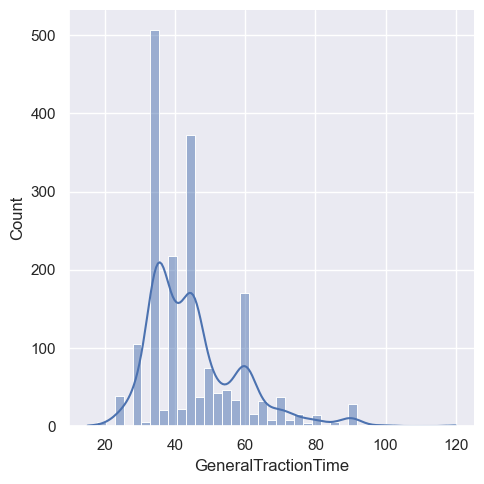

In [25]:
sns.displot(data=df_inc, x="GeneralTractionTime", kde=True)

### Expanding exclusion criteria to expand follow-up %

Primary reason for data issues are loss of patients due to follow-up. So we must exclude patients that did not complete follow-up questionnaires.

In [34]:
df_inc2 = df_inc.copy()

In [35]:
col_postop_1yr_scores = [
  'HHS5to11mScoreLast',
  'HOSADL5to11mScoreLast',
  'HOSSport5to11mScoreLast',
  'QOL5to11mScoreLast',
]
df_inc2 = df_inc2.dropna(subset=col_postop_1yr_scores)
df_inc2['age'].count()


892

In [49]:
traction_breakdown(df_inc2)

Traction breakdown:
≥40min: 528 pts
≥45min: 401 pts
≥50min: 204 pts
≥55min: 149 pts
≥60min: 118 pts
≥65min: 42 pts
≥70min: 34 pts
≥75min: 21 pts
≥80min: 16 pts
≥85min: 14 pts
≥90min: 12 pts


In [37]:
df_inc2.describe()

,age,GeneralTractionTime,GeneralSurgeryTime,surgery_yr,HHSScoreprept,HHS5to11mScoreLast,HHS11to23mScoreLast,HOSADLScoreprept,HOSADL5to11mScoreLast,HOSADL11to23mScoreLast,HOSSportScoreprept,HOSSport5to11mScoreLast,HOSSport11to23mScoreLast,QOLScoreprept,QOL5to11mScoreLast,QOL11to23mScoreLast
count,892.000000,892.000000,887.000000,892.000000,892.000000,892.00000,538.000000,892.000000,892.000000,539.00000,892.000000,892.000000,530.000000,892.000000,892.000000,511.000000
mean,31.315022,43.193946,84.216460,2013.607623,62.724664,80.51704,83.088848,74.049204,88.467007,90.52256,52.310101,71.431278,78.394717,40.853285,69.673430,74.293249
std,9.373200,11.940718,21.723962,2.004111,12.992900,15.20553,15.102732,16.223875,13.168883,12.83055,24.193286,26.171789,24.965618,17.668529,22.163877,22.516550
min,19.000000,15.000000,8.000000,2010.000000,12.100000,14.30000,26.400000,8.820000,14.580000,15.62000,0.000000,0.000000,0.000000,0.480000,0.430000,2.030000
25%,23.000000,35.000000,70.000000,2012.000000,53.900000,70.40000,71.500000,64.547500,84.732500,87.50000,36.110000,55.560000,65.882500,28.447500,54.320000,59.705000
50%,30.000000,40.000000,80.000000,2013.000000,64.900000,84.70000,84.700000,76.470000,92.650000,95.59000,52.780000,77.780000,88.890000,40.375000,74.105000,80.650000
75%,38.000000,45.000000,90.000000,2015.000000,70.400000,95.70000,95.700000,86.760000,98.357500,98.53000,69.440000,92.860000,100.000000,53.065000,88.917500,93.700000
max,58.000000,100.000000,190.000000,2018.000000,100.100000,100.10000,100.100000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,96.190000,100.000000,100.000000


In [38]:
col_postop_2yr_scores = [
  'HHS11to23mScoreLast',
  'HOSADL11to23mScoreLast',
  'HOSSport11to23mScoreLast',
  'QOL11to23mScoreLast',
]

In [46]:
df_inc2_2yr_na = df_inc2[
  (df_inc2['HHS11to23mScoreLast'].isna()) |
  (df_inc2['HOSADL11to23mScoreLast'].isna()) |
  (df_inc2['HOSSport11to23mScoreLast'].isna()) |
  (df_inc2['QOL11to23mScoreLast'].isna())
]
df_inc2_2yr_na['age'].count()

387

### Adjusting data for >80% followup at 2 years

**100% follow up at 1 year** has been applied to the data with **892 patients left**
If we are to apply 100% follow up at 2 years we will need to drop 387 patients (43% of our dataset). We can do better than this by checking the traction breakdown and dropping the patients that had fast traction times (less important data) and ensuring **>80% follow up at 2 years**.

In [50]:
traction_breakdown(df_inc2_2yr_na)

Traction breakdown:
≥40min: 252 pts
≥45min: 197 pts
≥50min: 116 pts
≥55min: 88 pts
≥60min: 70 pts
≥65min: 29 pts
≥70min: 25 pts
≥75min: 15 pts
≥80min: 11 pts
≥85min: 10 pts
≥90min: 8 pts


In [71]:
df_inc2[
  ((df_inc2['HHS11to23mScoreLast'].isna()) |
  (df_inc2['HOSADL11to23mScoreLast'].isna()) |
  (df_inc2['HOSSport11to23mScoreLast'].isna()) |
  (df_inc2['QOL11to23mScoreLast'].isna())) &
  (df_inc2['GeneralTractionTime'] < 50)
]['age'].count()

271

In [66]:
df_inc3 = df_inc2.drop(index=df_inc2[
  ((df_inc2['HHS11to23mScoreLast'].isna()) |
  (df_inc2['HOSADL11to23mScoreLast'].isna()) |
  (df_inc2['HOSSport11to23mScoreLast'].isna()) |
  (df_inc2['QOL11to23mScoreLast'].isna())) &
  (df_inc2['GeneralTractionTime'] < 50)
].index)
df_inc3['age'].count()

621

In [70]:
df_inc3.describe()

,age,GeneralTractionTime,GeneralSurgeryTime,surgery_yr,HHSScoreprept,HHS5to11mScoreLast,HHS11to23mScoreLast,HOSADLScoreprept,HOSADL5to11mScoreLast,HOSADL11to23mScoreLast,HOSSportScoreprept,HOSSport5to11mScoreLast,HOSSport11to23mScoreLast,QOLScoreprept,QOL5to11mScoreLast,QOL11to23mScoreLast
count,621.000000,621.000000,616.000000,621.000000,621.000000,621.000000,513.000000,621.000000,621.000000,513.000000,621.000000,621.000000,512.000000,621.000000,621.000000,506.000000
mean,31.877617,45.294686,87.360390,2013.668277,62.365217,81.323833,83.188304,73.593543,89.011369,90.465049,51.659871,71.758309,78.383867,40.199775,70.860209,74.252490
std,9.448391,13.269603,24.101681,2.031869,13.159092,14.659333,15.130479,16.203864,12.445565,12.996830,24.202258,25.604903,25.129531,17.507179,21.241215,22.568235
min,19.000000,15.000000,8.000000,2010.000000,13.200000,22.000000,26.400000,8.820000,23.210000,15.620000,0.000000,0.000000,0.000000,0.480000,9.150000,2.030000
25%,24.000000,35.000000,70.000000,2012.000000,53.900000,71.500000,73.700000,63.330000,85.290000,87.500000,35.710000,55.560000,65.287500,28.260000,56.550000,59.687500
50%,31.000000,45.000000,80.000000,2013.000000,64.900000,84.700000,84.700000,76.470000,93.330000,95.590000,52.780000,77.780000,88.890000,39.940000,74.840000,80.735000
75%,39.000000,53.000000,100.000000,2016.000000,70.400000,95.700000,95.700000,85.940000,97.060000,98.530000,69.440000,91.670000,100.000000,52.930000,89.250000,93.665000
max,58.000000,100.000000,190.000000,2018.000000,100.100000,100.100000,100.100000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,96.190000,100.000000,100.000000


We have dropped 271 patients with no follow up in 2 years and traction times <50 mins. This leaves us with a **cohort of 621 patients** and a follow up of `513/621 ~ 82.6%` at 2 years

In [72]:
df_inc3["GeneralTractionTime"].describe()

count    621.000000
mean      45.294686
std       13.269603
min       15.000000
25%       35.000000
50%       45.000000
75%       53.000000
max      100.000000
Name: GeneralTractionTime, dtype: float64

In [68]:
traction_breakdown(df_inc3)

Traction breakdown:
≥40min: 392 pts
≥45min: 320 pts
≥50min: 204 pts
≥55min: 149 pts
≥60min: 118 pts
≥65min: 42 pts
≥70min: 34 pts
≥75min: 21 pts
≥80min: 16 pts
≥85min: 14 pts
≥90min: 12 pts


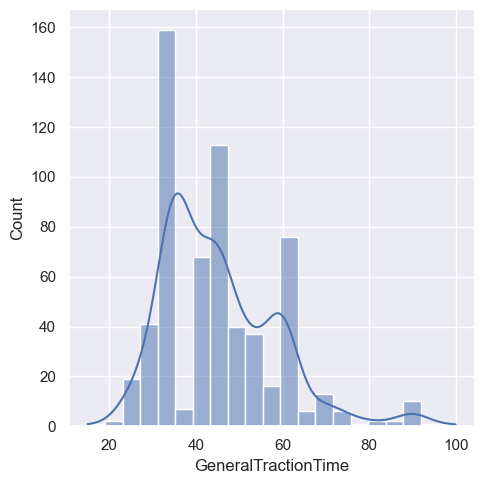

In [69]:
sns.displot(data=df_inc3, x="GeneralTractionTime", kde=True)

In [ ]:
profile = ProfileReport(df_inc3, title="Profile Report", minimal=True)
profile.to_file("pandas_profile.html")

In [74]:
# final dataframe
dff = df_inc3.copy()

In [94]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 621 entries, 10 to 3503
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   side                            621 non-null    category
 1   Sex                             621 non-null    category
 2   age                             621 non-null    int64   
 3   Procedure                       621 non-null    category
 4   Surgeon                         621 non-null    category
 5   PreDiagRevision                 621 non-null    bool    
 6   PreDiagLabTear                  621 non-null    bool    
 7   PreDiagCam                      621 non-null    bool    
 8   PreDiagPincer                   621 non-null    bool    
 9   ProcLTDwPres                    621 non-null    bool    
 10  ProcLTDwRefix                   621 non-null    bool    
 11  ProcCamDecom                    621 non-null    bool    
 12  ProcRimDecom        

In [93]:
# 2 cohorts, based on traction time > 60 > mins
df_fast = dff[dff['GeneralTractionTime'] < 60]
df_slow = dff[~dff.index.isin(df_fast.index)]
print("pts <60 min traction: {}".format(df_fast['age'].count()))
print("pts >60 min traction: {}".format(df_slow['age'].count()))

pts <60 min traction: 503
pts >60 min traction: 118


In [117]:
dff['age'].count() - dff[dff['Sex'] == 'F']['Sex'].count()

320

In [128]:
col_table1 = [
  'n', 
  'Traction Time', 
  'Surgical Time', 
  'Age', 
  'Female', 
  'Male', 
  'Labral Tear',
  'Cam Lesion', 
  'Pincer Lesion',
  'Labral Repair',
  'Labral Debridement',
  'Cam Decompression',
  'Pincer Resection'
]

def cohort_demo(*dfs):
  cohort_series = []
  for df in dfs:
    female_count = df[df['Sex'] == 'F']['Sex'].count()
    demo_series = [
      df['age'].count(),
      "{0:.1f} ± {1:.1f}".format(df['GeneralTractionTime'].mean(), df['GeneralTractionTime'].std()),
      "{0:.1f} ± {1:.1f}".format(df['GeneralSurgeryTime'].mean(), df['GeneralSurgeryTime'].std()),
      "{0:.1f} ± {1:.1f}".format(df['age'].mean(), df['age'].std()),
      "{0} ({1:.1f}%)".format(female_count, female_count/df['age'].count() * 100),
      "{0} ({1:.1f}%)".format(df['age'].count() - female_count, (1-female_count/df['age'].count()) * 100),
      "{0} ({1:.1f}%)".format(df['PreDiagLabTear'].sum(), df['PreDiagLabTear'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['PreDiagCam'].sum(), df['PreDiagCam'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['PreDiagPincer'].sum(), df['PreDiagPincer'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcLTDwRefix'].sum(), df['ProcLTDwRefix'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcLTDwPres'].sum(), df['ProcLTDwPres'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcCamDecom'].sum(), df['ProcCamDecom'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcRimDecom'].sum(), df['ProcRimDecom'].mean() * 100),
    ]   
    cohort_series.append(demo_series)
  return pd.DataFrame(cohort_series, index=['Total', 'Cohort 1', 'Cohort 2'], columns=col_table1).T

cohort_demo(dff, df_fast, df_slow)

,Total,Cohort 1,Cohort 2
n,621,503,118
Traction Time,45.3 ± 13.3,40.4 ± 8.0,66.3 ± 10.2
Surgical Time,87.4 ± 24.1,80.4 ± 18.0,117.6 ± 24.0
Age,31.9 ± 9.4,31.7 ± 9.3,32.8 ± 10.1
Female,301 (48.5%),254 (50.5%),47 (39.8%)
Male,320 (51.5%),249 (49.5%),71 (60.2%)
Labral Tear,621 (100.0%),503 (100.0%),118 (100.0%)
Cam Lesion,619 (99.7%),502 (99.8%),117 (99.2%)
Pincer Lesion,180 (29.0%),106 (21.1%),74 (62.7%)
Labral Repair,532 (85.7%),426 (84.7%),106 (89.8%)


In [142]:
timelines_prom = [
  'Baseline',
  # '6 Months Postop',
  '1 Year Postop',
  '2 Years Postop'
]
score_types = [
  'mHHS',
  'HOS-ADL',
  'HOS-SS',
  'iHOT'
]

scores_index_prom = pd.MultiIndex.from_product([timelines_prom, score_types], names=['Timeline', 'Score Type'])

col_scores = {
  "HSS": [
    'HHSScoreprept',
    'HHS5to11mScoreLast',
    'HHS11to23mScoreLast'
  ],
  "HOSADL": [
    'HOSADLScoreprept',
    'HOSADL5to11mScoreLast',
    'HOSADL11to23mScoreLast'
  ],
  "HOSSS": [
    'HOSSportScoreprept',
    'HOSSport5to11mScoreLast',
    'HOSSport11to23mScoreLast'
  ],
  "HOT": [
    'QOLScoreprept',
    'QOL5to11mScoreLast',
    'QOL11to23mScoreLast'
  ]
}

def cohort_scores(*dfs):
  score_data = []
  for df in dfs:
    score_series = []
    for i in range(3):
      score_series += [
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HSS"][i]].mean(), df[col_scores["HSS"][i]].std()),
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HOSADL"][i]].mean(), df[col_scores["HOSADL"][i]].std()),
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HOSSS"][i]].mean(), df[col_scores["HOSSS"][i]].std()),
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HOT"][i]].mean(), df[col_scores["HOT"][i]].std()),
      ]
    score_data.append(pd.Series(score_series, index=scores_index_prom))
  return pd.concat(score_data, axis=1)

df_scores = cohort_scores(df_fast, df_slow)
df_scores.columns = ['Cohort 1', 'Cohort 2']
df_scores

Cohort 1     Cohort 2
Timeline       Score Type                          
Baseline       mHHS        62.0 ± 13.1  63.8 ± 13.4
               HOS-ADL     73.2 ± 16.4  75.3 ± 15.1
               HOS-SS      50.7 ± 24.2  55.6 ± 23.8
               iHOT        39.9 ± 17.5  41.3 ± 17.6
1 Year Postop  mHHS        81.6 ± 14.1  80.4 ± 16.7
               HOS-ADL     89.4 ± 11.8  87.6 ± 15.0
               HOS-SS      72.0 ± 25.4  70.8 ± 26.8
               iHOT        71.2 ± 20.4  69.3 ± 24.5
2 Years Postop mHHS        83.2 ± 15.3  83.2 ± 13.8
               HOS-ADL     90.3 ± 13.4   92.2 ± 8.7
               HOS-SS      78.3 ± 25.7  79.4 ± 19.7
               iHOT        74.1 ± 22.9  75.8 ± 18.9

In [146]:
timelines_mcid = [
  'Baseline',
  # '6 Months Postop',
  '1 Year Postop',
  '2 Years Postop'
]
score_types = [
  'mHHS',
  'HOS-ADL',
  'HOS-SS',
  'iHOT'
]

scores_index_mcid = pd.MultiIndex.from_product([timelines_mcid[1:], score_types], names=['Timeline', 'Score Type'])

col_scores = {
  "HSS": [
    'HHSScoreprept',
    'HHS5to11mScoreLast',
    'HHS11to23mScoreLast'
  ],
  "HOSADL": [
    'HOSADLScoreprept',
    'HOSADL5to11mScoreLast',
    'HOSADL11to23mScoreLast'
  ],
  "HOSSS": [
    'HOSSportScoreprept',
    'HOSSport5to11mScoreLast',
    'HOSSport11to23mScoreLast'
  ],
  "HOT": [
    'QOLScoreprept',
    'QOL5to11mScoreLast',
    'QOL11to23mScoreLast'
  ]
}

mcid_ref = {
  "HSS": 8.2,
  "HOSADL": 8.3,
  "HOSSS": 14.5,
  "HOT": 12.1
}

def cohort_mcid(*dfs):
  score_data = []
  for df in dfs:
    score_series = []
    for i in range(1,3):
      df_delta_hss = df[col_scores["HSS"][i]] - df[col_scores["HSS"][i-1]]
      df_delta_hosadl = df[col_scores["HOSADL"][i]] - df[col_scores["HOSADL"][i-1]]
      df_delta_hosss = df[col_scores["HOSSS"][i]] - df[col_scores["HOSSS"][i-1]]
      df_delta_hot = df[col_scores["HOT"][i]] - df[col_scores["HOT"][i-1]]
      score_series += [
        "{0:.1f}%".format(df_delta_hss.mean() / mcid_ref['HSS'] * 100),
        "{0:.1f}%".format(df_delta_hosadl.mean() / mcid_ref['HOSADL'] * 100),
        "{0:.1f}%".format(df_delta_hosss.mean() / mcid_ref['HOSSS'] * 100),
        "{0:.1f}%".format(df_delta_hot.mean() / mcid_ref['HOT'] * 100),
      ]
    score_data.append(pd.Series(score_series, index=scores_index_mcid))
  return pd.concat(score_data, axis=1)

df_scores = cohort_mcid(df_fast, df_slow)
df_scores.columns = ['Cohort 1', 'Cohort 2']
df_scores

Cohort 1 Cohort 2
Timeline       Score Type                  
1 Year Postop  mHHS         238.2%   201.4%
               HOS-ADL      194.8%   147.4%
               HOS-SS       146.5%   104.8%
               iHOT         258.6%   231.2%
2 Years Postop mHHS          21.1%    -0.5%
               HOS-ADL        9.3%    37.0%
               HOS-SS        44.2%    58.6%
               iHOT          23.6%    22.5%

### Multivariable analysis via Logistical Regression

Matched and unmatched based upon controlling for:

- age
- gender
- baseline PROM score
- preoperative diagnosis
- intraoperative procedures

### Design matrices (endog & exog)
To fit most of the models covered by `statsmodels`, you will need to create two design matrices. The first is a matrix of **endogenous variables** (i.e. dependent, response, regressand, etc.). The second is a matrix of **exogenous variables** (i.e. independent, predictor, regressor, etc.).

In [159]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices("""HHS5to11mScoreLast ~ 
                  age +
                  Sex +
                  HHSScoreprept +
                  HOSADLScoreprept +
                  HOSSportScoreprept +
                  QOLScoreprept +
                  PreDiagRevision + 
                  PreDiagLabTear + 
                  PreDiagCam +
                  PreDiagPincer +
                  ProcLTDwPres +
                  ProcLTDwRefix +
                  ProcCamDecom +
                  ProcRimDecom +
                  PCVCamLesion
                  """, data=dff, return_type='dataframe')
display(y.head())
display(X.head())

,HHS5to11mScoreLast
10,95.7
11,100.1
13,84.7
14,70.4
21,100.1


,Intercept,Sex[T.M],PreDiagRevision[T.True],PreDiagLabTear[T.True],PreDiagCam[T.True],PreDiagPincer[T.True],ProcLTDwPres[T.True],ProcLTDwRefix[T.True],ProcCamDecom[T.True],ProcRimDecom[T.True],PCVCamLesion[T.True],age,HHSScoreprept,HOSADLScoreprept,HOSSportScoreprept,QOLScoreprept
10,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,41.0,68.2,85.29,86.11,54.50
11,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,32.0,62.7,69.12,44.44,34.84
13,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,33.0,70.4,69.12,67.86,48.17
14,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,25.0,84.7,92.65,86.11,68.10
21,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,31.0,56.1,86.76,66.67,65.90


In [160]:
mod = sm.OLS(y, X) # describe the model
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     HHS5to11mScoreLast   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     9.367
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           1.16e-15
Time:                        00:42:49   Log-Likelihood:                -2499.6
No. Observations:                 621   AIC:                             5023.
Df Residuals:                     609   BIC:                             5076.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  21.7758      4.776      4.559      0.000      12.397      31.155
Sex[T.M]                    2.1022      1.162      1.810      0.071      -0.179       4.384
PreDiagRevision[T.True]  7.067e-13   1.97e-13      3.582      0.000    3.19e-13    1.09e-12
PreDiagLabTear[T.True]     21.7758      4.776      4.559      0.000      12.397      31.155
PreDiagCam[T.True]         -5.7443      9.709     -0.592      0.554     -24.812      13.324
PreDiagPincer[T.True]      -6.1577      2.744     -2.244      0.025     -11.548      -0.768
ProcLTDwPres[T.True]        7.2347      9.860      0.734      0.463     -12.129      26.599
ProcLTDwRefix[T.True]       7.5879      9.748      0.778      0.437     -11.557      26.732
ProcCamDecom[T.True]       21.7758      4.776      4.559      0.000      12.397      31.155
ProcRimDecom[T.True]        4.7720      2.750      1.735      0.083      -0.630      10.173
PCVCamLesion[T.True]    -4.436e-16   2.47e-15     -0.180      0.858    -5.3e-15    4.41e-15
age                        -0.1777      0.059     -3.030      0.003      -0.293      -0.063
HHSScoreprept               0.2561      0.068      3.772      0.000       0.123       0.389
HOSADLScoreprept           -0.0248      0.068     -0.363      0.716      -0.159       0.109
HOSSportScoreprept          0.0229      0.036      0.637      0.524      -0.048       0.094
QOLScoreprept               0.0959      0.055      1.750      0.081      -0.012       0.204
==============================================================================
Omnibus:                       34.241   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.641
Skew:                          -0.607   Prob(JB):                     4.07e-09
Kurtosis:                       3.135   Cond. No.                     3.72e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.95e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""